# Used Car Pricing Algorithm

## Feature Engineering

In [ ]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

In [ ]:
# monthly mileage
df["monthly_mileage"] = round(df["mvr_mileage"]/df["age_months"],1)

In [ ]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

In [ ]:
# consolidate fuel types
mapping = {"Lpg / Natural Gas":"Natural Gas"
           ,"Unleaded / Premium Unleaded":"Premium Unleaded"
           ,"E85; Unleaded ":"E85 / Unleaded"
           ,"E85 / Unleaded; Premium Unleaded":"Premium Unleaded"
           ,"Compressed Natural Gas; Unleaded":"Natural Gas"
           ,"Unleaded; Unleaded / E85":"E85 / Unleaded"
           ,"E85 / Unleaded; Unleaded / E85 ":"E85 / Unleaded"
           ,"Unleaded / Electric":"Electric / Unleaded"
           ,"Compressed Natural Gas / Unleaded":"Natural Gas"
           ,"Premium Unleaded; Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded / Unleaded":"E85 / Unleaded"
           ,"Compressed Natural Gas":"Natural Gas"
           ,"Unleaded / Unleaded":"Unleaded"
           ,"Premium Unleaded / Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded":"E85 / Unleaded"
           ,"Unleaded / E85":"E85 / Unleaded"
          }

df['fuel_type'] = df['fuel_type'].map(mapping).fillna(df['fuel_type'])

In [ ]:
# zip first five
df['zip'] = df['zip'].str[:5]

### Local Features

In [99]:
from uszipcode import SearchEngine
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive) 

In [100]:
def get_population_density_and_income(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        return pd.Series([result.population_density
                          ,result.median_household_income
                          ,result.median_home_value
                         ])
    else:
        return pd.Series([None, None, None])

In [101]:
# apply get_population_density_and_income to each value in zip_list
zip_list = pd.DataFrame(df['zip'].unique(), columns=['zip'])
zip_list[['population_density', 'median_income', 'median_home_value']] = zip_list['zip'].apply(get_population_density_and_income)
df = df.merge(zip_list, on='zip', how='left')

### Economic

In [102]:
df["mvr_purchase_yearmonth"] = df["mvr_purchase_date"].dt.strftime('%Y-%m')

In [103]:
# federal reserve economic data (fred)
from fredapi import Fred
fred = Fred(api_key_file='private/fred_api_key.txt')

#### Used Car Price Index

In [104]:
# BLS: Used cars and trucks in U.S. city average
used_car_price_index = fred.get_series('CUUR0000SETA02')
used_car_price_index.name = "used_car_price_index"
used_car_price_index.index = used_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
used_car_price_index.index = used_car_price_index.index.strftime('%Y-%m')
df = df.join(used_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### New Car Price Index

In [105]:
# BLS: New cars and trucks in U.S. city average
new_car_price_index = fred.get_series('CUSR0000SETA01')
new_car_price_index.name = "new_car_price_index"
new_car_price_index.index = new_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
new_car_price_index.index = new_car_price_index.index.strftime('%Y-%m')
df = df.join(new_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### Gas Prices

In [106]:
gas_price_index = fred.get_series('GASREGW')
gas_price_index.name = "gas_price_index"
gas_price_index = gas_price_index.groupby(pd.Grouper(freq='M')).mean().resample('M').mean()
gas_price_index.index = gas_price_index.index + pd.DateOffset(months=1) # shift index 
gas_price_index.index = gas_price_index.index.strftime('%Y-%m')
df = df.join(gas_price_index, on="mvr_purchase_yearmonth", how="left")

#### Consumer Sentiment

In [107]:
consumer_sentiment_index = fred.get_series('UMCSENT')
consumer_sentiment_index.name = "consumer_sentiment_index"
consumer_sentiment_index.index = consumer_sentiment_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
consumer_sentiment_index.index = consumer_sentiment_index.index.strftime('%Y-%m')
df = df.join(consumer_sentiment_index, on="mvr_purchase_yearmonth", how="left")

### "High Value Features" Vehicle Options
- Optional features will be useful in combination with make/model/trim
- Standard+Optional features will be useful in combination with make/model/trim

In [108]:
from tqdm import tqdm
tqdm.pandas()

In [109]:
def make_series(x):
    return pd.Series(x, dtype = object)

#### Optional

In [111]:
# produce dummy vars
hvf_optional = df["hvf_optional"]
hvf_optional_df = pd.get_dummies(hvf_optional.progress_apply(make_series).stack()).groupby(level=0).sum()
hvf_optional_df = hvf_optional_df.fillna(0)
hvf_optional_df = hvf_optional_df.add_prefix('hvf_opt_')
print(hvf_optional_df.shape)

100%|██████████| 6359934/6359934 [29:54<00:00, 3544.70it/s]  


(2371882, 77)


#### Optional and Standard

In [136]:
# function to append two lists
def combine_hvf(row):
    if row["hvf_optional"] is None:
        row["hvf_optional"] = []
    if row["hvf_standard"] is None:
        row["hvf_standard"] = []
    else:
        return list(set(list(row["hvf_optional"]) + list(row["hvf_standard"])))

In [138]:
# combine unique features across two lists
hvf_all = df.progress_apply(combine_hvf, axis=1)

100%|██████████| 6359934/6359934 [03:18<00:00, 32046.86it/s]


In [145]:
# create dummy vars
hvf_all_df = pd.get_dummies(hvf_all.progress_apply(make_series).stack()).groupby(level=0).sum()
hvf_all_df = hvf_all_df.fillna(0)
hvf_all_df = hvf_all_df.add_prefix('hvf_all_')
print(hvf_optional_df.shape)

100%|██████████| 6359934/6359934 [38:07<00:00, 2780.02it/s]  


(2371882, 77)


#### Flag Records with No Features Data

In [151]:
df["hvf_opt_missing"] = 0
df.loc[df["hvf_optional"].isna(),"hvf_opt_missing"] = 1

In [152]:
df["hvf_std_missing"] = 0
df.loc[df["hvf_standard"].isna(),"hvf_std_missing"] = 1

## Data Split

In [2]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# shuffle dataframe for good measure
df = df.sample(frac=1, random_state=42)

# create StratifiedShuffleSplit object by make_model_trim column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, temp_index = next(sss.split(df, df['make_model_trim_encode']))

# create StratifiedShuffleSplit object by make_model_trim column again
df_temp = df.loc[temp_index]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
val_index, test_index = next(sss.split(df_temp, df_temp['make_model_trim_encode']))

# split dataframe into train, validate, and test sets
train = df.loc[train_index]
validate = df.loc[temp_index[val_index]]
test = df.loc[temp_index[test_index]]


In [3]:
print("Train")
print_rows(train)
print("\nValidate")
print_rows(validate)
print("\nTest")
print_rows(test)

Train
Rows: 4,451,953

Validate
Rows: 1,278,347

Test
Rows: 629,634


## Target Encoding

In [5]:
import category_encoders as ce

In [6]:
# fit encoder for make/model/trim
encoder = ce.TargetEncoder(cols=['make_model_trim_encode'])
encoder.fit(train, train["mvr_price"])

# apply transformation
train = encoder.transform(train)
validate = encoder.transform(validate)
test = encoder.transform(test)

In [7]:
# fit encoder for make/model/trim
encoder = ce.TargetEncoder(cols=['make_model_encode'])
encoder.fit(train, train["mvr_price"])

# apply transformation
train = encoder.transform(train)
validate = encoder.transform(validate)
test = encoder.transform(test)

## HVF Dimsionality Reduction

In [8]:
hvf_optional_df = hvf_optional_df.clip(upper=1)
hvf_all_df = hvf_all_df.clip(upper=1)

In [9]:
from sklearn.decomposition import PCA

def reduce_hvf(df,pca=None,comp_prefix=""):
    
    # compute pca if not provided
    if not pca:
        pca = PCA(n_components=9)
        pca.fit(df)
    
    transformed_df = pca.transform(df)
    transformed_df = pd.DataFrame(transformed_df, columns=['comp_0','comp_1', 'comp_2'
                                                       ,'comp_3','comp_4', 'comp_5'
                                                       ,'comp_6','comp_7', 'comp_8'
                                                                  ])
    transformed_df = transformed_df.add_prefix(comp_prefix)
    
    transformed_df.index = df.index
    print_shape(transformed_df)
    return transformed_df,pca

In [10]:
train_index = train.index
validate_index = validate.index
test_index = test.index

### Optional

In [11]:
hvf_optional_train = hvf_optional_df.loc[hvf_optional_df.index.intersection(train_index),:]
hvf_optional_validate = hvf_optional_df.loc[hvf_optional_df.index.intersection(validate_index),:]
hvf_optional_test = hvf_optional_df.loc[hvf_optional_df.index.intersection(test_index),:]

In [12]:
hvf_optional_train,pca_train = reduce_hvf(hvf_optional_train,None,comp_prefix = "hvf_opt_")
hvf_optional_validate,_ = reduce_hvf(hvf_optional_validate,pca_train,comp_prefix = "hvf_opt_")
hvf_optional_test,_ = reduce_hvf(hvf_optional_test,pca_train,comp_prefix = "hvf_opt_")

Rows: 1,660,970 
Columns: 9
Rows: 476,238 
Columns: 9
Rows: 234,674 
Columns: 9


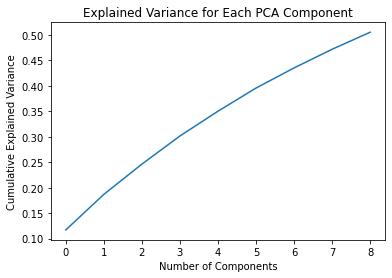

In [13]:
import matplotlib.pyplot as plt

# plot the explained variance for each component
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance for Each PCA Component')
plt.show()


### Optional and Standard

In [14]:
hvf_all_train = hvf_all_df.loc[hvf_all_df.index.intersection(train_index),:]
hvf_all_validate = hvf_all_df.loc[hvf_all_df.index.intersection(validate_index),:]
hvf_all_test = hvf_all_df.loc[hvf_all_df.index.intersection(test_index),:]

In [15]:
hvf_all_train,pca_train = reduce_hvf(hvf_all_train,None,comp_prefix = "hvf_all_")
hvf_all_validate,_ = reduce_hvf(hvf_all_validate,pca_train,comp_prefix = "hvf_all_")
hvf_all_test,_ = reduce_hvf(hvf_all_test,pca_train,comp_prefix = "hvf_all_")

Rows: 3,625,850 
Columns: 9
Rows: 1,040,234 
Columns: 9
Rows: 512,838 
Columns: 9


### Merge with DF

In [16]:
train = train.merge(hvf_optional_train,how='left', left_index=True, right_index=True)
validate = validate.merge(hvf_optional_validate,how='left', left_index=True, right_index=True)
test = test.merge(hvf_optional_test,how='left', left_index=True, right_index=True)

In [17]:
train = train.merge(hvf_all_train,how='left', left_index=True, right_index=True)
validate = validate.merge(hvf_all_validate,how='left', left_index=True, right_index=True)
test = test.merge(hvf_all_test,how='left', left_index=True, right_index=True)

In [22]:
hvf_cols = ['hvf_opt_comp_0', 'hvf_opt_comp_1', 'hvf_opt_comp_2', 'hvf_opt_comp_3',
       'hvf_opt_comp_4', 'hvf_opt_comp_5', 'hvf_opt_comp_6', 'hvf_opt_comp_7',
       'hvf_opt_comp_8', 'hvf_all_comp_0', 'hvf_all_comp_1', 'hvf_all_comp_2',
       'hvf_all_comp_3', 'hvf_all_comp_4', 'hvf_all_comp_5', 'hvf_all_comp_6',
       'hvf_all_comp_7', 'hvf_all_comp_8']

In [27]:
train[hvf_cols] = train[hvf_cols].fillna(0)
validate[hvf_cols] = validate[hvf_cols].fillna(0)
test[hvf_cols] = test[hvf_cols].fillna(0)

In [18]:
print_shape(train)
print_shape(validate)
print_shape(test)

Rows: 4,451,953 
Columns: 58
Rows: 1,278,347 
Columns: 58
Rows: 629,634 
Columns: 58
